## Making figure 3

Start by importing modules, data files and defining functions.

In [1]:
import arviz as az
import jax.numpy as jnp
import numpyro
import matplotlib.pylab as plt
import numpy.random as rand

from makeCorner import *

In [2]:
cdf_file = "../data/RUNS/peak_run_no_delta_middle_z_until_0dot08.cdf"
data = az.from_netcdf(cdf_file)
samps = data.posterior.stack(draws=("chain", "draw"))

In [10]:
def sigmoid_no_delta(low, high, width, middle, zs):
    return (high - low) / (1 + jnp.exp(-(1/width)*(zs - middle))) + low

def computing_gaussian_prob(value, mean, std):
    return (1/(std * np.sqrt(2*np.pi))) * np.exp(-(value - mean)**2/(2.*std**2))

def computing_uniform_prob(a, b):
    return 1/(b-a)

zs = np.linspace(0,2,500)

### Computing prior samples

In [11]:
fp_matrix = np.zeros((len(range(samps.log_f_peak.size)), len(zs)))

prior_log_f_peak = rand.uniform(-6,0, samps.log_f_peak.size)
prior_high_f_peak = rand.uniform(-6,0, samps.log_f_peak.size)
prior_width_f_peak = rand.uniform(-1,1, samps.log_f_peak.size)
prior_middle_f_peak = rand.uniform(0, 0.8, samps.log_f_peak.size)

for i in range(samps.log_f_peak.size):
    f_peak_r = sigmoid_no_delta(prior_log_f_peak[i],
                               prior_high_f_peak[i],
                               10.**prior_width_f_peak[i],
                               prior_middle_f_peak[i],
                               zs,
                              )
    fp_matrix[i, :] = f_peak_r

only_prior_fp_median = np.median(fp_matrix, axis = 0)
only_prior_fp_quantile_5 = np.quantile(fp_matrix,0.05,axis=0)
only_prior_fp_quantile_95 = np.quantile(fp_matrix,0.95,axis=0)

In [7]:
mu_matrix = np.zeros((len(range(samps.log_f_peak.size)), len(zs)))

prior_mu = rand.uniform(15, 60, samps.log_f_peak.size)
prior_high_mu = rand.uniform(15, 60, samps.log_f_peak.size)
prior_width_mu = rand.uniform(-1,1, samps.log_f_peak.size)
prior_middle_mu = rand.uniform(0, 0.8, samps.log_f_peak.size)

for i in range(samps.log_f_peak.size):
    mu_r = sigmoid_no_delta(prior_mu[i],
                               prior_high_mu[i],
                               10.**prior_width_mu[i],
                               prior_middle_mu[i],
                               zs,
                              )
    mu_matrix[i, :] = mu_r

only_prior_mu_median = np.median(mu_matrix, axis = 0)
only_prior_mu_quantile_5 = np.quantile(mu_matrix,0.05,axis=0)
only_prior_mu_quantile_95 = np.quantile(mu_matrix,0.95,axis=0)

In [9]:
sigma_matrix = np.zeros((len(range(samps.log_f_peak.size)), len(zs)))

prior_sigma = rand.uniform(1.5,15, samps.log_f_peak.size)
prior_high_sigma = rand.uniform(1.5,15, samps.log_f_peak.size)
prior_width_sigma = rand.uniform(-1,1, samps.log_f_peak.size)
prior_middle_sigma = rand.uniform(0, 0.8, samps.log_f_peak.size)

for i in range(samps.log_f_peak.size):
    sigma_r = sigmoid_no_delta(prior_sigma[i],
                               prior_high_sigma[i],
                               10.**prior_width_sigma[i],
                               prior_middle_sigma[i],
                               zs,
                              )
    sigma_matrix[i, :] = sigma_r

only_prior_sigma_median = np.median(sigma_matrix, axis = 0)
only_prior_sigma_quantile_5 = np.quantile(sigma_matrix, 0.05, axis=0)
only_prior_sigma_quantile_95 = np.quantile(sigma_matrix, 0.95, axis=0)

### Computing conditional priors

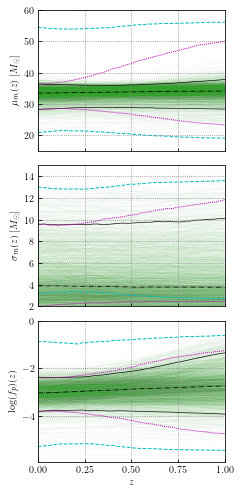

In [13]:
cm = 1/2.54
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8.75*cm, 3*5.9*cm))
zs = np.linspace(0,1,500)
z_ref = 0

ax1.set_rasterization_zorder(2)
mu_matrix = np.zeros((len(range(samps.mu_m1.size)), len(zs)))
mu_matrix_post = np.zeros((len(range(samps.mu_m1.size)), len(zs)))
low_value_z_matrix = np.zeros(len(samps.high_mu.values))
for i in range(samps.mu_m1.size):
    okay = False
    while not okay:
        prior_high_mu = rand.uniform(15, 60)
        prior_width_mu = rand.uniform(-1,1)
        prior_width_non_log_mu = 10.**prior_width_mu
        prior_middle_mu = rand.uniform(0, 0.8)
        posterior_value_z_0 = sigmoid_no_delta(samps.mu_m1.values[i],
                               samps.high_mu.values[i],
                               10.**samps.log_width_mu.values[i],
                               samps.middle_z_mu.values[i],
                               0,
                              )
        value_at_z_0 = samps.mu_m1.values[i] + (
            (samps.high_mu.values[i] - samps.mu_m1.values[i])/(1 + np.exp(samps.middle_z_mu.values[i]/samps.width_mu.values[i]))
        )
        intermediate_step_prior = np.exp(prior_middle_mu/(10**(prior_width_mu)))
        low_z_value_mu = (prior_high_mu - (value_at_z_0*(1 + intermediate_step_prior))) / (-1*intermediate_step_prior)
        
        prob_low_prior = computing_uniform_prob(15, 60)
        exp_inv = 1 - (1/(1 + np.exp(-(z_ref - prior_middle_mu)/prior_width_non_log_mu)))
        C = 1 # 1e4
        rejection_param = prob_low_prior * exp_inv**(-1) / C
    
        rejection_threshold = rand.uniform(0, 1)

        if rejection_threshold <= rejection_param:
            okay = True

    mu_r = sigmoid_no_delta(low_z_value_mu,
                               prior_high_mu,
                               10.**prior_width_mu,
                               prior_middle_mu,
                               zs,
                              )
    mu_matrix[i, :] = mu_r
    
    mu_r_post = sigmoid_no_delta(samps.mu_m1.values[i],
                               samps.high_mu.values[i],
                               10.**samps.log_width_mu.values[i],
                               samps.middle_z_mu.values[i],
                               zs,
                              )
    ax1.plot(zs, mu_r_post, lw = 0.05, color='#33a02c', alpha = 0.2, zorder = 1)
    mu_matrix_post[i, :] = mu_r_post

median_mu = np.median(mu_matrix, axis = 0)
median_mu_post = np.median(mu_matrix_post, axis = 0)
ax1.set_ylim(15, 60)
ax1.set_ylabel(r"$\mu_{m}(z) \: [M_\odot]$", fontsize = 10)
ax1.tick_params(axis='y', labelsize=10)
ax1.plot(zs, median_mu_post, "-.", c="k", zorder = 1, lw = 0.8)
ax1.plot(zs,np.quantile(mu_matrix_post,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
ax1.plot(zs,np.quantile(mu_matrix_post,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
# ax1.plot(zs, median_mu, c="m", zorder = 1, lw = 0.8, linestyle=(0,(1,1)))
ax1.plot(zs,np.quantile(mu_matrix,0.05,axis=0), zorder = 1, color='m', lw=1, alpha=1, linestyle=(0,(1,1)))
ax1.plot(zs,np.quantile(mu_matrix,0.95,axis=0), zorder = 1, color='m', lw=1, alpha=1, linestyle=(0,(1,1)))
# ax1.plot(zs, only_prior_mu_median, zorder = 1, color='c', lw=1, linestyle="dashed")
ax1.plot(zs, only_prior_mu_quantile_5, zorder = 1, color='c', lw=1, linestyle="dashed")
ax1.plot(zs, only_prior_mu_quantile_95, zorder = 1, color='c', lw=1, linestyle="dashed")

ax2.set_rasterization_zorder(2)
sig_matrix = np.zeros((len(range(samps.sig_m1.size)), len(zs)))
sig_matrix_post = np.zeros((len(range(samps.sig_m1.size)), len(zs)))
low_value_z_matrix = np.zeros(len(samps.sig_m1.values))
for i in range(samps.sig_m1.size):
    okay = False
    while not okay:
        prior_sig = rand.uniform(1.5,15)
        prior_high_sig = rand.uniform(1.5,15)
        prior_width_sig = rand.uniform(-1,1)
        prior_width_non_log_sig = 10.**prior_width_sig
        prior_middle_sig = rand.uniform(0, 0.8)
        posterior_value_z_0 = sigmoid_no_delta(samps.sig_m1.values[i],
                               samps.high_sig.values[i],
                               10.**samps.log_width_sig.values[i],
                               samps.middle_z_sig.values[i],
                               0,
                              )


        value_at_z_0 = samps.sig_m1.values[i] + (
            (samps.high_sig.values[i] - samps.sig_m1.values[i])/(1 + np.exp(samps.middle_z_sig.values[i]/samps.width_sig.values[i]))
        )
        intermediate_step_prior = np.exp(prior_middle_sig/(10**(prior_width_sig)))
        low_z_value_sig = (prior_high_sig - (value_at_z_0*(1 + intermediate_step_prior))) / (-1*intermediate_step_prior)
        
        prob_low_prior = computing_uniform_prob(1.5, 15)
        exp_inv = 1 - (1/(1 + np.exp(-(z_ref - prior_middle_sig)/prior_width_non_log_sig)))
        C = 1 # 1e4
        rejection_param = prob_low_prior * exp_inv**(-1) / C
    
        rejection_threshold = rand.uniform(0, 1)

        if rejection_threshold <= rejection_param:
            okay = True
        
    sig_r = sigmoid_no_delta(low_z_value_sig,
                               prior_high_sig,
                               10.**prior_width_sig,
                               prior_middle_sig,
                               zs,
                              )
    sig_matrix[i, :] = sig_r
    
    sig_r_post = sigmoid_no_delta(samps.sig_m1.values[i],
                               samps.high_sig.values[i],
                               10.**samps.log_width_sig.values[i],
                               samps.middle_z_sig.values[i],
                               zs,
                              )
    ax2.plot(zs, sig_r_post, lw = 0.05, color='#33a02c', alpha = 0.2, zorder = 1)
    sig_matrix_post[i, :] = sig_r_post

median_sig = np.median(sig_matrix, axis = 0)
median_sig_post = np.median(sig_matrix_post, axis = 0)
ax2.set_ylim(2, 15)
ax2.set_ylabel(r"$\sigma_{m}(z) \: [M_\odot]$", fontsize = 10)
ax2.tick_params(axis='y', labelsize=10)
ax2.plot(zs, median_sig_post, "-.", c="k", zorder = 1, lw = 0.8)
ax2.plot(zs,np.quantile(sig_matrix_post,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
ax2.plot(zs,np.quantile(sig_matrix_post,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
# ax2.plot(zs, median_sig, c="m", zorder = 1, lw = 0.8, linestyle=(0,(1,1)))
ax2.plot(zs,np.quantile(sig_matrix,0.05,axis=0), zorder = 1, color='m', lw=1, alpha=1, linestyle=(0,(1,1)))
ax2.plot(zs,np.quantile(sig_matrix,0.95,axis=0), zorder = 1, color='m', lw=1, alpha=1, linestyle=(0,(1,1)))
# ax2.plot(zs, only_prior_sigma_median, zorder = 1, color='c', lw=1, linestyle="dashed")
ax2.plot(zs, only_prior_sigma_quantile_5, zorder = 1, color='c', lw=1, linestyle="dashed")
ax2.plot(zs, only_prior_sigma_quantile_95, zorder = 1, color='c', lw=1, linestyle="dashed")

ax3.set_rasterization_zorder(2)
fp_matrix = np.zeros((len(range(samps.log_f_peak.size)), len(zs)))
fp_matrix_post = np.zeros((len(range(samps.log_f_peak.size)), len(zs)))
low_value_z_matrix = np.zeros(len(samps.log_f_peak.values))
for i in range(samps.log_f_peak.size):
    okay = False
    while not okay:
        prior_fpeak = rand.uniform(-6, 0)
        prior_high_fpeak = rand.uniform(-6, 0)
        prior_width_fpeak = rand.uniform(-1,1)
        prior_width_non_log_fpeak = 10.**prior_width_fpeak
        prior_middle_fpeak = rand.uniform(0, 0.8)
        posterior_value_z_0 = sigmoid_no_delta(samps.log_f_peak.values[i],
                               samps.log_high_f_peak.values[i],
                               10.**samps.log_width_f_peak.values[i],
                               samps.middle_z_f_peak.values[i],
                               0,
                              )

        intermediate_step = 1 + np.exp(samps.middle_z_f_peak.values[i]/samps.width_f_peak.values[i])
        value_at_z_0 = samps.log_f_peak.values[i] + (
            (samps.log_high_f_peak.values[i] - samps.log_f_peak.values[i])/(intermediate_step)
        )
        intermediate_step_prior = np.exp(prior_middle_fpeak/(10**(prior_width_fpeak)))
        low_z_value_fp = (prior_high_fpeak - (value_at_z_0*(1 + intermediate_step_prior))) / (-1*intermediate_step_prior)
        
        prob_low_prior = computing_uniform_prob(-6, 0)
        exp_inv = 1 - (1/(1 + np.exp(-(z_ref - prior_middle_fpeak)/prior_width_non_log_fpeak)))
        C = 1 # 1e4
        rejection_param = prob_low_prior * exp_inv**(-1) / C
    
        rejection_threshold = rand.uniform(0, 1)

        if rejection_threshold <= rejection_param:
            okay = True
        
    fp_r = sigmoid_no_delta(low_z_value_fp,
                               prior_high_fpeak,
                               10.**prior_width_fpeak,
                               prior_middle_fpeak,
                               zs,
                              )
    fp_matrix[i, :] = fp_r
    
    fp_r_post = sigmoid_no_delta(samps.log_f_peak.values[i],
                               samps.log_high_f_peak.values[i],
                               10.**samps.log_width_f_peak.values[i],
                               samps.middle_z_f_peak.values[i],
                               zs,
                              )
    ax3.plot(zs, fp_r_post, lw = 0.05, color='#33a02c', alpha = 0.2, zorder = 1)
    fp_matrix_post[i, :] = fp_r_post

median_fp = np.median(fp_matrix, axis = 0)
median_fp_post = np.median(fp_matrix_post, axis = 0)
ax3.set_xlim(0,1)
ax3.set_ylim(-5.9, 0)
ax3.set_xlabel(r"$z$", fontsize = 10)
ax3.set_ylabel(r"$\log(f_p)(z)$", fontsize = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax3.plot(zs, median_fp_post, "-.", c="k", zorder = 1, lw = 0.8)
ax3.plot(zs,np.quantile(fp_matrix_post,0.05,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
ax3.plot(zs,np.quantile(fp_matrix_post,0.95,axis=0), zorder = 1, color='k', lw=0.65, alpha=1)
# ax3.plot(zs, median_fp, c="m", zorder = 1, lw = 0.8, linestyle=(0,(1,1)))
ax3.plot(zs,np.quantile(fp_matrix,0.05,axis=0), zorder = 1, color='m', lw=1, alpha=1, linestyle=(0,(1,1)))
ax3.plot(zs,np.quantile(fp_matrix,0.95,axis=0), zorder = 1, color='m', lw=1, alpha=1, linestyle=(0,(1,1)))
# ax3.plot(zs, only_prior_fp_median, zorder = 1, color='c', lw=1, linestyle="dashed")
ax3.plot(zs, only_prior_fp_quantile_5, zorder = 1, color='c', lw=1, linestyle="dashed")
ax3.plot(zs, only_prior_fp_quantile_95, zorder = 1, color='c', lw=1, linestyle="dashed")


plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)

# Adjust layout
plt.tight_layout()
plt.savefig("One_plot_conditional_prior.pdf", dpi=500, bbox_inches="tight")
plt.show()